<a href="https://colab.research.google.com/github/helloitsdaksh/Tensorflow_colab/blob/main/05_transfer_learning_in_tensorflow_part_2_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#05. Transfer Learning with TensorFlow Part 2: Fine-tuning

In the previous notebook, we covered transfered learning feature extraction, now it;s time to learn about a new kind of transfer learning: Fine-Tuning
or feature extraction transfer learning, you may only train the top 1-3 layers of a pre-trained model with your own data, in fine-tuning transfer learning, you might train 1-3+ layers of a pre-trained model (where the '+' indicates that many or all of the layers could be trained).

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/05-transfer-learning-feature-extraction-vs-fine-tuning.png)
*Feature extraction transfer learning vs. fine-tuning transfer learning. The main difference between the two is that in fine-tuning, more layers of the pre-trained model get unfrozen and tuned on custom data. This fine-tuning usually takes more data than feature extraction to be effective.*

## What we're going to cover

We're going to go through the follow with TensorFlow:

- Introduce fine-tuning, a type of transfer learning to modify a pre-trained model to be more suited to your data
- Using the Keras Functional API (a differnt way to build models in Keras)
- Using a smaller dataset to experiment faster (e.g. 1-10% of training samples of 10 classes of food)
- Data augmentation (how to make your training dataset more diverse without adding more data)
- Running a series of modelling experiments on our Food Vision data
  - Model 0: a transfer learning model using the Keras Functional API
  - Model 1: a feature extraction transfer learning model on 1% of the data with data augmentation
  - Model 2: a feature extraction transfer learning model on 10% of the data with data augmentation
  - Model 3: a fine-tuned transfer learning model on 10% of the data
  - Model 4: a fine-tuned transfer learning model on 100% of the data
- Introduce the ModelCheckpoint callback to save intermediate training results
- Compare model experiments results using TensorBoard

## How you can use this notebook

You can read through the descriptions and the code (it should all run, except for the cells which error on purpose), but there's a better option.

Write all of the code yourself.

Yes. I'm serious. Create a new notebook, and rewrite each line by yourself. Investigate it, see if you can break it, why does it break?

You don't have to write the text descriptions but writing the code yourself is a great way to get hands-on experience.

Don't worry if you make mistakes, we all do. The way to get better and make less mistakes is to **write more code**.

In [ ]:
!nvidia-smi

Thu Sep 16 09:47:21 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8    24W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper functions
In previous notebooks, we've created a bunch of helper functions, now we could rewrite them all, however, this is tedious.

In [2]:
!wget https://raw.githubusercontent.com/helloitsdaksh/Tensorflow_colab/main/Extras/helper_functions.py

--2021-09-17 19:44:52--  https://raw.githubusercontent.com/helloitsdaksh/Tensorflow_colab/main/Extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10115 (9.9K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]   9.88K  --.-KB/s    in 0s      

2021-09-17 19:44:52 (51.2 MB/s) - ‘helper_functions.py’ saved [10115/10115]



In [3]:
from helper_functions import *

## Let's get some data
This time we're going to see how we can use the pretrained models within `tf.keras.applications` and apply them to our own problem(Recognizing images of food).



In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip 
unzip_data("10_food_classes_10_percent.zip")


--2021-09-16 09:47:25--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.200.128, 209.85.234.128, 74.125.124.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|209.85.200.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   169MB/s    in 1.0s    

2021-09-16 09:47:26 (169 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
# check out how many images and subdirectories are in our dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent

In [ ]:
# create training and test directory paths
train_dir = "/content/10_food_classes_10_percent/train"
test_dir = "/content/10_food_classes_10_percent/test"

In [ ]:
import tensorflow as tf

In [ ]:
IMG_SIZE = (224,224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                            image_size = IMG_SIZE,
                                                                            label_mode = 'categorical',
                                                                            batch_size = 32)
test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                           image_size = IMG_SIZE,
                                                                           label_mode = 'categorical',
                                                                           batch_size = 32)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
# check out class name of out dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [ ]:
# See an example batch of data
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[150.35715   64.35714   64.07143 ]
   [148.40306   63.377552  59.765305]
   [147.13776   64.78062   56.566326]
   ...
   [209.15305  235.15305  248.15305 ]
   [211.       237.       250.      ]
   [209.57137  235.57137  248.57137 ]]

  [[148.09694   62.09694   61.09694 ]
   [147.93367   62.933674  59.933674]
   [145.41325   65.44388   58.5     ]
   ...
   [208.72961  234.72961  247.72961 ]
   [211.0051   237.0051   250.0051  ]
   [211.97449  237.97449  250.97449 ]]

  [[146.79082   58.790813  57.57653 ]
   [147.58673   64.2296    60.729595]
   [144.47449   65.61224   63.066326]
   ...
   [210.78574  236.78574  249.78574 ]
   [209.       235.       248.      ]
   [210.07654  236.07654  249.07654 ]]

  ...

  [[138.62245   88.19393   89.408195]
   [137.54066   87.11214   88.3264  ]
   [137.64278   87.428505  86.428505]
   ...
   [200.       224.       234.42853 ]
   [200.07144  227.07144  234.07144 ]
   [201.       229.       233.      ]]

  [[138.49486   88.49486   89.4948

### Model 0: Building a transfer learning model using the Keras Functional API

Alright, our data is tensor-ified, let's build a model.

To do so we're going to be using the [`tf.keras.applications`](https://www.tensorflow.org/api_docs/python/tf/keras/applications) module as it contains a series of already trained (on ImageNet) computer vision models as well as the Keras Functional API to construct our model.

We're going to go through the following steps:

1. Instantiate a pre-trained base model object by choosing a target model such as [`EfficientNetB0`](https://www.tensorflow.org/api_docs/python/tf/keras/applications/EfficientNetB0) from `tf.keras.applications`, setting the `include_top` parameter to `False` (we do this because we're going to create our own top, which are the output layers for the model).
2. Set the base model's `trainable` attribute to `False` to freeze all of the weights in the pre-trained model.
3. Define an input layer for our model, for example, what shape of data should our model expect?
4. [Optional] Normalize the inputs to our model if it requires. Some computer vision models such as `ResNetV250` require their inputs to be between 0 & 1. 

> 🤔 **Note:** As of writing, the `EfficientNet` models in the `tf.keras.applications` module do not require images to be normalized (pixel values between 0 and 1) on input, where as many of the other models do. I posted [an issue to the TensorFlow GitHub](https://github.com/tensorflow/tensorflow/issues/42506) about this and they confirmed this. 

5. Pass the inputs to the base model.
6. Pool the outputs of the base model into a shape compatible with the output activation layer (turn base model output tensors into same shape as label tensors). This can be done using [`tf.keras.layers.GlobalAveragePooling2D()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D) or [`tf.keras.layers.GlobalMaxPooling2D()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalMaxPool2D?hl=en) though the former is more common in practice.
7. Create an output activation layer using `tf.keras.layers.Dense()` with the appropriate activation function and number of neurons.
8. Combine the inputs and outputs layer into a model using [`tf.keras.Model()`](https://www.tensorflow.org/api_docs/python/tf/keras/Model).
9. Compile the model using the appropriate loss function and choose of optimizer.
10. Fit the model for desired number of epochs and with necessary callbacks (in our case, we'll start off with the TensorBoard callback).

Woah... that sounds like a lot. Before we get ahead of ourselves, let's see it in practice.

In [ ]:
# 1. Create the base model using tf.keras.applicaiton with efficientnet
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top= False, classes =10)

# 2. Freeze the base model(so the underlying pre-trained patterns aren't updated during training)
base_model.trainable = False

# 3. Create Inputs into our model
inputs = tf.keras.layers.Input(shape=(224,224,3),name='input_layer')

# 4. If using ResNet50V2, add this to speed up convergence, remove for EfficientNet
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model
x = base_model(inputs)
print(f"shape after passing inputs throught base modelL{x.shape}")

# 6. Average pool the outputs of the base model(aggreate all the most important information, reduce number of computation)
x = tf.keras.layers.GlobalAveragePooling2D(name = "global_average_pooling") (x)
print(f"Shape after GlobalAveragingPooling2D: {x.shape}")

# 7. Create output activation layer
outputs = tf.keras.layers.Dense(10, activation ='softmax',name = 'output_layer')(x)

# 8. Combine the inputs and outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

#9. Compile the model
model_0.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

# 10. Fit the model
history_0 = model_0.fit(train_data_10_percent,
                        epochs = 5,
                        steps_per_epoch = len(train_data_10_percent),
                        validation_data = test_data_10_percent,
                        validation_steps = int(0.25 * len(test_data_10_percent)),
                        callbacks=[create_tensorboard_callback(dir_name="transfer_learning", 
                                                               experiment_name= "10_percent_feature_extract")]
                        )


16719872/16705208 [==============================] - 0s 0us/step
shape after passing inputs throught base modelL(None, 7, 7, 1280)
Shape after GlobalAveragingPooling2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extract/20210916-094739
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 44s 467ms/step - loss: 1.8544 - accuracy: 0.4360 - val_loss: 1.3411 - val_accuracy: 0.6957
Epoch 2/5
24/24 [==============================] - 6s 251ms/step - loss: 1.1207 - accuracy: 0.7520 - val_loss: 0.9205 - val_accuracy: 0.7845
Epoch 3/5
24/24 [==============================] - 6s 248ms/step - loss: 0.8165 - accuracy: 0.8147 - val_loss: 0.7412 - val_accuracy: 0.8240
Epoch 4/5
24/24 [==============================] - 6s 248ms/step - loss: 0.6828 - accuracy: 0.8267 - val_loss: 0.6511 - val_accuracy: 0.8421
Epoch 5/5
24/24 [==============================] - 9s 350ms/step - loss: 0.5887 - accuracy: 0.8600 - val_loss: 0.5875 - val_accuracy: 0.8520


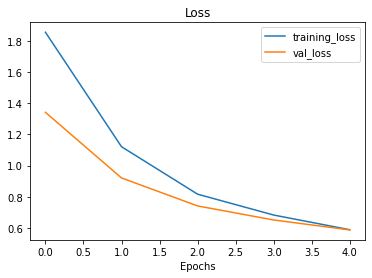

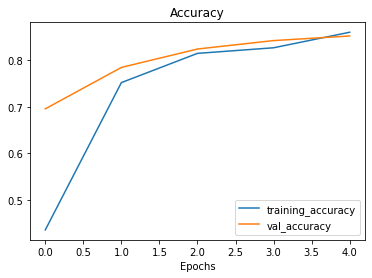

In [ ]:
plot_loss_curves(history_0)

In [ ]:
model_0.evaluate(test_data_10_percent)

79/79 [==============================] - 11s 128ms/step - loss: 0.6094 - accuracy: 0.8368


[0.6094149351119995, 0.8367999792098999]

In [ ]:
# Check layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_dwcon

In [ ]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, None, None, 3 7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, None, None, 3 0           normalization[0][0]              
_____________________________________________________________________________________

In [ ]:
#how about summary of whole model
model_0.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling (Glob (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


## Getting a feature vector from a trained model

> 🤔 **Question:** What happens with the `tf.keras.layers.GlobalAveragePooling2D()` layer? I haven't seen it before.

The [`tf.keras.layers.GlobalAveragePooling2D()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D) layer transforms a 4D tensor into a 2D tensor by averaging the values across the inner-axes.

The previous sentence is a bit of a mouthful, so let's see an example.

In [ ]:
#Define the input shape 
input_shape = (1,4,4,3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

# Pass the random tensor through a global average pooling 2D layer
global_average_pooling = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_average_pooling}\n")

# check the shapes of different tensor
print(f"shape of input tensor:{input_tensor.shape}")
print(f"shape of global averaged poole tensor:{global_average_pooling.shape}")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]

shape of input tensor:(1, 4, 4, 3)
shape of global averaged poole tensor:(1, 3)


In [ ]:
# Let's replicate the Global Average Pooling 
tf.reduce_mean(input_tensor, axis = [1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

In [ ]:
global_max_pool = tf.keras.layers.GlobalMaxPool2D()(input_tensor)
global_max_pool.numpy()

array([[0.9058464, 1.1603122, 1.6994323]], dtype=float32)

## Running a series of transfer learning experiments
We've seen the incredible resutls transfer learning can get with only 10% of the training data, but how does it go with 1% of the training data.... how about we set up a bunch of experiemetns to find out:

Why don't we answer that question while running the following modelling experiments:
1. `model_1`: Use feature extraction transfer learning on 1% of the training data with data augmentation.
2. `model_2`: Use feature extraction transfer learning on 10% of the training data with data augmentation.
3. `model_3`: Use fine-tuning transfer learning on 10% of the training data with data augmentation.
4. `model_4`: Use fine-tuning transfer learning on 100% of the training data with data augmentation.

## Getting data ready for model_1

In [ ]:
# Download the data and unzip the  data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

--2021-09-16 20:36:16--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.194.128, 173.194.196.128, 64.233.191.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.194.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip.1’

10_food_classes_1_p 100%[===================>] 127.42M   170MB/s    in 0.7s    

2021-09-16 20:36:16 (170 MB/s) - ‘10_food_classes_1_percent.zip.1’ saved [133612354/133612354]



In [ ]:
# Create training and test dirs
train_dir = "10_food_classes_1_percent/train"
test_dir = "10_food_classes_1_percent/test"

In [ ]:
# How many images are we working with?
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There a

In [ ]:
# Setup data loaders
IMG_SIZE = (224,224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                           image_size = IMG_SIZE,
                                                                           label_mode = "categorical",
                                                                           batch_size = 32)

test_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                           image_size = IMG_SIZE,
                                                                           label_mode = "categorical",
                                                                           batch_size = 32)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


### Adding data augmentation directly into the model
to add data augmentation right into our models, we can use the layers inside:
* `tf.keras.layers.experimental.preprocessing()`
> 🤔 **Note:** At the time of writing, the preprocessing layers we're using for data augmentation are in *experimental* status within the in TensorFlow library. This means although the layers should be considered stable, the code may change slightly in a future version of TensorFlow. For more information on the other preprocessing layers avaiable and the different methods of data augmentation, check out the [Keras preprocessing layers guide](https://keras.io/guides/preprocessing_layers/) and the [TensorFlow data augmentation guide](https://www.tensorflow.org/tutorials/images/data_augmentation).

To use data augmentation right within our model we'll create a Keras Sequential model consisting of only data preprocessing layers, we can then use this Sequential model within another Functional model.

If that sounds confusing, it'll make sense once we create it in code.

The data augmentation transformations we're going to use are:
* [RandomFlip](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/RandomFlip) - flips image on horizontal or vertical axis.
* [RandomRotation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/RandomRotation) - randomly rotates image by a specified amount.
* [RandomZoom](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/RandomZoom) - randomly zooms into an image by specified amount.
* [RandomHeight](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/RandomHeight) - randomly shifts image height by a specified amount.
* [RandomWidth](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/RandomWidth) - randomly shifts image width by a specified amount.
* [Rescaling](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Rescaling) - normalizes the image pixel values to be between 0 and 1, this is worth mentioning because it is required for some image models but since we're using the `tf.keras.applications` implementation of `EfficientNetB0`, it's not required.

There are more option but these will do for now.

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [ ]:
# create data augmentation stage with horizontal flip, rotations, zooms, etc
data_augmentation = keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetB0
], name = "data_augmentation")

(-0.5, 442.5, 603.5, -0.5)

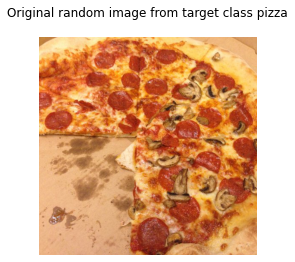

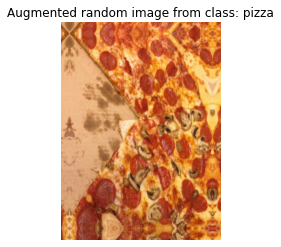

In [ ]:
# view a random image and compare it to augmented verison
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os 
import random

target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image


# Read in random image
image = mpimg.imread(random_image_path)
plt.imshow(image)
plt.title(f"Original random image from target class {target_class}\n")
plt.axis(False)

# Now let's plot our random image
augmented_img = data_augmentation(image)
plt.figure()
plt.imshow(augmented_img/255)
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False)

## Model 1: Feature extraction transfer learning on 1% of the data with data augmentation

In [ ]:
# setup input shape and base model, freezing the base model layers
input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top= False)
base_model.trainable = False

# Create the input layer
inputs = layers.Input(shape=input_shape,name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model the inputs (after augmmentation) and don't train it
x = base_model(x,training = False)

# Pool the output features of the base model
x = layers.GlobalAveragePooling2D(name = "global_average_pooling_layer") (x)

# Put a dense layer on as the output 
outputs = layers.Dense(10, activation = "softmax",name ="output_layer") (x)

# Make the model using inputs and outputs
model_1 = keras.Model(inputs,outputs)

# compile the model
model_1.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

# Fit the model
history_1 = model_1.fit(train_data_1_percent,
                        epochs = 5,
                        steps_per_epoch = len(train_data_1_percent),
                        validation_data = test_data_1_percent,
                        validation_steps = int(0.25* len(test_data_1_percent)),
                        callbacks=[create_tensorboard_callback("transfer_learning", "1_percent_data_aug")]
                        )

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20210916-210909
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


3/3 [==============================] - 42s 5s/step - loss: 2.2971 - accuracy: 0.0857 - val_loss: 2.2337 - val_accuracy: 0.2171
Epoch 2/5
3/3 [==============================] - 6s 2s/step - loss: 2.0675 - accuracy: 0.2857 - val_loss: 2.1051 - val_accuracy: 0.2944
Epoch 3/5
3/3 [==============================] - 7s 3s/step - loss: 1.9019 - accuracy: 0.4857 - val_loss: 1.9900 - val_accuracy: 0.3668
Epoch 4/5
3/3 [==============================] - 5s 2s/step - loss: 1.7375 - accuracy: 0.6000 - val_loss: 1.8975 - val_accuracy: 0.4178
Epoch 5/5
3/3 [==============================] - 5s 2s/step - loss: 1.5316 - accuracy: 0.7571 - val_loss: 1.8249 - val_accuracy: 0.4359


In [ ]:
# we got accuracy of 40% by using jsut 7 images

In [ ]:
model_1.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
# Evaluate on the test data
results_1_percent_data_aug = model_1.evaluate(test_data_1_percent)
results_1_percent_data_aug

79/79 [==============================] - 11s 137ms/step - loss: 1.7819 - accuracy: 0.4804


[1.7819414138793945, 0.4803999960422516]

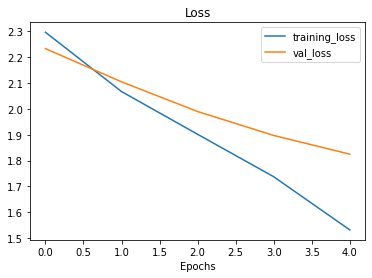

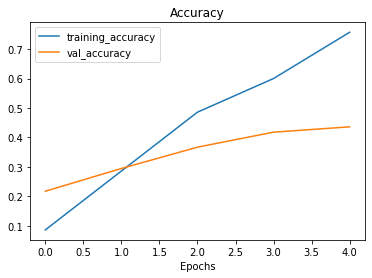

In [ ]:
plot_loss_curves(history_1)

## Model 2: Feature extraction transfer learning with 10% of data and data augmentation


In [4]:
# Get the 10% data of the 10 classes
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
unzip_data("10_food_classes_10_percent.zip")

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

--2021-09-17 19:44:59--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.128.128, 142.251.6.128, 74.125.70.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.128.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M   181MB/s    in 0.9s    

2021-09-17 19:45:00 (181 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [5]:
import tensorflow as tf
IMG_SIZE = (224,224)

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                            label_mode = "categorical",
                                                                            batch_size=32,#default
                                                                            image_size = IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                batch_size = 32,
                                                                image_size = IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [6]:
# Create model 2 with data augmentation built in
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

#Build Data Augmentation layer
data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2)
    # preprocessing.Rescaling(1./255) # if you're using efficient net then no need to rescale but need to ne added in ResNet.
], name ="data_augmentation_layer")

# Setup the input_shape for the model
input_shape = (224,224,3)

# Create a frozen base model (also called backbone)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create the inputs and outputs (including the layers in between)
inputs = layers.Input(shape = input_shape, name ="input_layer")
x = data_augmentation(inputs)
x = base_model(x,training = False)# pass augmented images to base model but keep it in inference mode, so batchnorm layers don't get updated: https://keras.io/guides/transfer_learning/#build-a-model 
x = layers.GlobalAveragePooling2D(name = "global_average_pooling2D_layer")(x)
outputs = layers.Dense(10, activation="softmax", name = "output_layer")(x)

# Create the model 2 using inputs and outputs
model_2 = tf.keras.Model(inputs,outputs)

# Compile the model
model_2.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metrics =['accuracy'])

16719872/16705208 [==============================] - 0s 0us/step


In [7]:
model_2.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation_layer (Seq (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling2D_lay (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


### Creating a ModelCheckpoint callback

Our model is compiled and ready to be fit, so why haven't we fit it yet?

Well, for this experiment we're going to introduce a new callback, the `ModelCheckpoint` callback.

The [`ModelCheckpoint`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint) callback gives you the ability to save your model, as a whole in the [`SavedModel`](https://www.tensorflow.org/tutorials/keras/save_and_load#save_the_entire_model) format or the [weights (patterns) only](https://www.tensorflow.org/tutorials/keras/save_and_load#manually_save_weights) to a specified directory as it trains. 

This is helpful if you think your model is going to be training for a long time and you want to make backups of it as it trains. It also means if you think your model could benefit from being trained for longer, you can reload it from a specific checkpoint and continue training from there.

For example, say you fit a feature extraction transfer learning model for 5 epochs and you check the training curves and see it was still improving and you want to see if fine-tuning for another 5 epochs could help, you can load the checkpoint, unfreeze some (or all) of the base model layers and then continue training.

In fact, that's exactly what we're going to do. 

But first, let's create a `ModelCheckpoint` callback. To do so, we have to specifcy a directory we'd like to save to.

In [8]:
# Set Checkpoint path 
checkpoint_path = "10_percent_model_checkpoints_weights/checkpoint.ckpt"

# Create a ModelCheckpoint callback to saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only = True,
                                                         save_best_only = False,
                                                         save_freq = "epoch",
                                                         verbose = 1)

In [9]:
# Fit the model
history_2 =  model_2.fit(train_data_10_percent,
                         epochs = 5,
                         steps_per_epoch = len(train_data_10_percent),
                         validation_data = test_data,
                         validation_steps = int(0.25 * len(test_data)),
                         callbacks = [create_tensorboard_callback(dir_name="transfer_learning",experiment_name="10_percent_data_aug"),
                                      checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20210917-194519
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 58s 892ms/step - loss: 2.0111 - accuracy: 0.3333 - val_loss: 1.5107 - val_accuracy: 0.6283

Epoch 00001: saving model to 10_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 2/5
24/24 [==============================] - 15s 632ms/step - loss: 1.3666 - accuracy: 0.6747 - val_loss: 1.0738 - val_accuracy: 0.7763

Epoch 00002: saving model to 10_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 3/5
24/24 [==============================] - 16s 654ms/step - loss: 1.0509 - accuracy: 0.7507 - val_loss: 0.8871 - val_accuracy: 0.7993

Epoch 00003: saving model to 10_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 4/5
24/24 [==============================] - 16s 649ms/step - loss: 0.8922 - accuracy: 0.7787 - val_loss: 0.7685 - val_accuracy: 0.8174

Epoch 00004: saving model to 10_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 5/5
24/24 [==============================] - 13s 510ms/step - loss: 0.7876 - accuracy: 0.8147 - val_loss

In [10]:
# Evaluate on the test data
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 11s 134ms/step - loss: 0.6796 - accuracy: 0.8260


[0.6795749068260193, 0.8259999752044678]

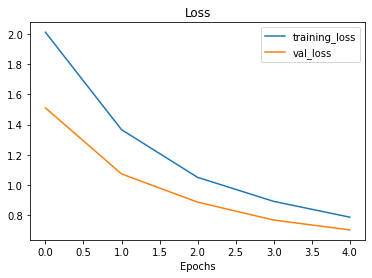

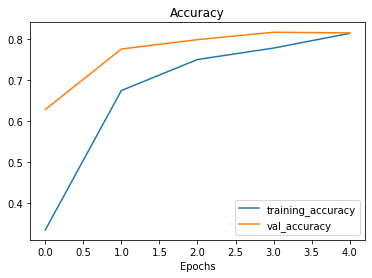

In [16]:
plot_loss_curves(history_2)

Looking at these, our model's performance with 10% of the data and data augmentation isn't as good as the model with 10% of the data without data augmentation (see `model_0` results above), however the curves are trending in the right direction, meaning if we decided to train for longer, its metrics would likely improve.

Since we checkpointed (is that a word?) our model's weights, we might as well see what it's like to load it back in. We'll be able to test if it saved correctly by evaluting it on the test data.

To load saved model weights you can use the the [`load_weights()`](https://www.tensorflow.org/tutorials/keras/save_and_load#checkpoint_callback_options) method, passing it the path where your saved weights are stored.

In [12]:
# Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 11s 129ms/step - loss: 0.6796 - accuracy: 0.8260


In [15]:
# If the results from our native model and the loaded weights are the same, this should output True
np.isclose(np.array(results_10_percent_data_aug), np.array(loaded_weights_model_results))

array([ True,  True])

In [14]:
# Check the difference between the two results
print(np.array(results_10_percent_data_aug) - np.array(loaded_weights_model_results))

[0. 0.]
[0. 0.]


## Model 3: Fine-tuning an existing model on 10% of the data

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/05-fine-tuning-an-efficientnet-model.png)
*High-level example of fine-tuning an EfficientNet model. Bottom layers (layers closer to the input data) stay frozen where as top layers (layers closer to the output data) are updated during training.*

So far our saved model has been trained using feature extraction transfer learning for 5 epochs on 10% of the training data and data augmentation.

This means all of the layers in the base model (EfficientNetB0) were frozen during training.

For our next experiment we're going to switch to fine-tuning transfer learning. This means we'll be using the same base model except we'll be unfreezing some of its layers (ones closest to the top) and running the model for a few more epochs.

The idea with fine-tuning is to start customizing the pre-trained model more to our own data.

> 🔑 **Note:** Fine-tuning usually works best *after* training a feature extraction model for a few epochs and with large amounts of data. For more on this, check out [Keras' guide on Transfer learning & fine-tuning](https://keras.io/guides/transfer_learning/).

We've verified our loaded model's performance, let's check out its layers.

In [17]:
model_2.layers

In [18]:
# what layers are there in our model_2
for layer in model_2.layers: 
  print(layer,layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f22dc30ef90> True
<keras.engine.sequential.Sequential object at 0x7f22dc30e550> True
<keras.engine.functional.Functional object at 0x7f22d0288fd0> False
<keras.layers.pooling.GlobalAveragePooling2D object at 0x7f22dc30ed90> True
<keras.layers.core.Dense object at 0x7f22d027fa90> True


In [21]:
# What layers are in our base model and are they trainable??
for i,layer in enumerate(model_2.layers[2].layers):
  print(i, layer.name,layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshape F

Beautiful. This is exactly what we're after. 

Now to fine-tune the base model to our own data, we're going to unfreeze the top 10 layers and continue training our model for another 5 epochs.

This means all of the base model's layers except for the last 10 will remain frozen and untrainable. And the weights in the remaining unfrozen layers will be updated during training.

Ideally, we should see the model's performance improve.

> 🤔 **Question:** How many layers should you unfreeze when training?

There's no set rule for this. You could unfreeze every layer in the pretrained model or you could try unfreezing one layer at a time. Best to experiment with different amounts of unfreezing and fine-tuning to see what happens. Generally, the less data you have, the less layers you want to unfreeze and the more gradually you want to fine-tune.

> 📖 **Resource:** The [ULMFiT (Universal Language Model Fine-tuning for Text Classification) paper](https://arxiv.org/abs/1801.06146) has a great series of experiments on fine-tuning models.

To begin fine-tuning, we'll unfreeze the entire base model by setting its `trainable` attribute to `True`. Then we'll refreeze every layer in the base model except for the last 10 by looping through them and setting their `trainable` attribute to `False`. Finally, we'll recompile the model.

In [23]:
# how many trainable variables are in our base model ?
print(len(model_2.layers[2].trainable_variables))

0


In [27]:
# To begin fine-tuning, let's start by setting the last 10 layers of our base_model.trainable equal to true
base_model.trainable = True

# Freeze all the layers except for the last 10
for layer in base_model.layers[:-10]:
  layer.trainable = False

# Let's recompile our model_2
model_2.compile(loss= tf.keras.losses.CategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001), # when fine-tuning you typically want to lower the learing rate
                metrics = ["accuracy"])


In [28]:
# Check which layers are tunable (trainable)
for i,layer in enumerate(model_2.layers[2].layers):
  print(i, layer.name,layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshape F

Nice! It seems all layers except for the last 10 are frozen and untrainable. This means only the last 10 layers of the base model along with the output layer will have their weights updated during training.

> 🤔 **Question:** Why did we recompile the model?

Every time you make a change to your models, you need to recompile them.

In our case, we're using the exact same loss, optimizer and metrics as before, except this time the learning rate for our optimizer will be 10x smaller than before (0.0001 instead of Adam's default of 0.001).

We do this so the model doesn't try to overwrite the existing weights in the pretrained model too fast. In other words, we want learning to be more gradual.

> 🔑 **Note:** There's no set standard for setting the learning rate during fine-tuning, though reductions of [2.6x-10x+ seem to work well in practice](https://arxiv.org/abs/1801.06146).

How many trainable variables do we have now?

In [31]:
print(len(model_2.trainable_variables))

12


In [37]:
# Fine tune for another 5 epochs
initial_epochs = 5
fine_tune_epochs = initial_epochs + 5 

#Refit the model (same as model_2 except with more trainable layers)

history_2_fine_tune = model_2.fit(train_data_10_percent,
                                  epochs = fine_tune_epochs,
                                  validation_data = test_data,
                                  validation_steps = int(0.25*len(test_data)),
                                  initial_epoch = history_2.epoch[-1],
                                  callbacks = [create_tensorboard_callback(dir_name="transfer_learning",experiment_name="10_percent_fine_tune_lat_10")]
                                  )

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_lat_10/20210917-202530
Epoch 5/10


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 27s 782ms/step - loss: 0.6804 - accuracy: 0.8027 - val_loss: 0.5789 - val_accuracy: 0.8191
Epoch 6/10
24/24 [==============================] - 15s 587ms/step - loss: 0.5385 - accuracy: 0.8427 - val_loss: 0.5394 - val_accuracy: 0.8289
Epoch 7/10
24/24 [==============================] - 12s 503ms/step - loss: 0.4845 - accuracy: 0.8467 - val_loss: 0.5466 - val_accuracy: 0.8158
Epoch 8/10
24/24 [==============================] - 12s 501ms/step - loss: 0.4376 - accuracy: 0.8627 - val_loss: 0.5112 - val_accuracy: 0.8388
Epoch 9/10
24/24 [==============================] - 14s 591ms/step - loss: 0.3908 - accuracy: 0.8827 - val_loss: 0.5463 - val_accuracy: 0.8257
Epoch 10/10
24/24 [==============================] - 15s 612ms/step - loss: 0.3517 - accuracy: 0.8987 - val_loss: 0.5121 - val_accuracy: 0.8306


In [38]:
# evaluate the fine-tune model
results_fine_tune_10_percent = model_2.evaluate(test_data
                                                )

79/79 [==============================] - 11s 127ms/step - loss: 0.4825 - accuracy: 0.8420


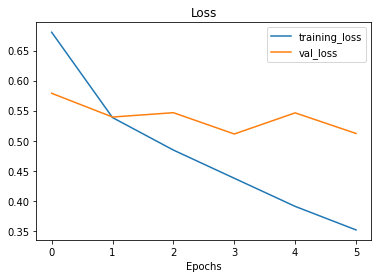

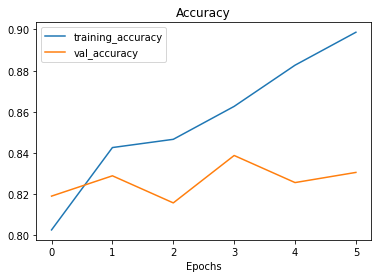

In [39]:
# checkout the loss curves
plot_loss_curves(history_2_fine_tune)

In [42]:
# Let's Compare the training histories

def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two model history objects.
    """
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    print(len(acc))

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    print(len(total_acc))
    print(total_acc)

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

5
11
[0.3333333432674408, 0.6746666431427002, 0.7506666779518127, 0.7786666750907898, 0.8146666884422302, 0.8026666641235352, 0.8426666855812073, 0.846666693687439, 0.862666666507721, 0.8826666474342346, 0.8986666798591614]


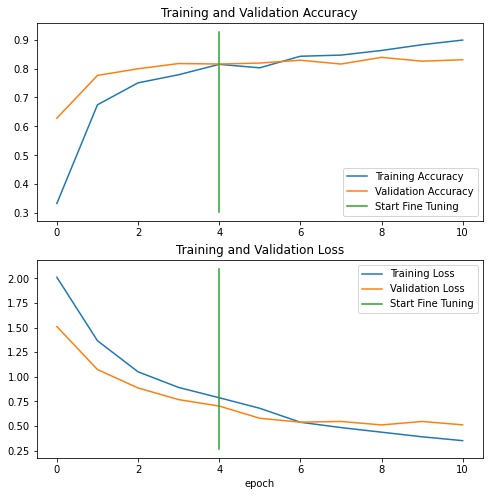

In [44]:
compare_historys(history_2,history_2_fine_tune,initial_epochs=5)

## Model 4: Fine-tuning an existing model all of the data

Enough talk about how fine-tuning a model usually works with more data, let's try it out.

We'll start by downloading the full version of our 10 food classes dataset.



In [45]:
# Download and unzip data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip 
unzip_data("10_food_classes_all_data.zip")

# Create the directories
train_dir = "10_food_classes_all_data/train"
test_dir = "10_food_classes_all_data/test"

--2021-09-17 20:43:55--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.234.128, 108.177.112.128, 74.125.124.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|209.85.234.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M   150MB/s    in 3.4s    

2021-09-17 20:43:58 (148 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [47]:
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/train'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/grilled_salmon'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ice_cream'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ramen'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/pizza'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_wings'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/sushi'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_curry'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/steak'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/fried_rice'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/hamburger'.

In [48]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224,224)

train_data_all_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                          label_mode = "categorical",
                                                                          image_size = IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode = "categorical",
                                                                image_size = IMG_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [49]:
# Evaluate model (this is the fine-tuned 10 percent of data version)
model_2.evaluate(test_data)

79/79 [==============================] - 11s 129ms/step - loss: 0.4825 - accuracy: 0.8420


[0.4824643135070801, 0.8420000076293945]

In [50]:
results_fine_tune_10_percent

[0.4824642539024353, 0.8420000076293945]

Now we'll revert the model back to the saved weights.

In [51]:
# Load model from checkpoint, that way we can fine-tune from the same stage the 10 percent data model was fine-tuned from
model_2.load_weights(checkpoint_path) #reverts model to saved weights

In [52]:
model_2.evaluate(test_data)

79/79 [==============================] - 11s 128ms/step - loss: 0.6796 - accuracy: 0.8260


[0.6795748472213745, 0.8259999752044678]

In [53]:
# Check to see if the above two results are the same (they should be)
results_10_percent_data_aug

[0.6795749068260193, 0.8259999752044678]

Alright, the previous steps might seem quite confusing but all we've done is:
1. Trained a feature extraction transfer learning model for 5 epochs on 10% of the data (with all base model layers frozen) and saved the model's weights using `ModelCheckpoint`.
2. Fine-tuned the same model on the same 10% of the data for a further 5 epochs with the top 10 layers of the base model unfrozen.
3. Saved the results and training logs each time.
4. Reloaded the model from 1 to do the same steps as 2 but with all of the data.

The same steps as 2?

Yeah, we're going to fine-tune the last 10 layers of the base model with the full dataset for another 5 epochs but first let's remind ourselves which layers are trainable.

In [54]:
# Check which layers are tuneable in the whole model
for layer_number, layer in enumerate(model_2.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation_layer True
2 efficientnetb0 True
3 global_average_pooling2D_layer True
4 output_layer True


In [55]:
# Check which layers are tuneable in the base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshape F

Looking good! The last 10 layers are trainable (unfrozen).

We've got one more step to do before we can begin fine-tuning.

Do you remember what it is?

I'll give you a hint. We just reloaded the weights to our model and what do we need to do every time we make a change to our models?

Recompile them!

This will be just as before.

In [56]:
model_2.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
                metrics = ["accuracy"])

In [58]:
# Continue to train and fine-tune the model to our data
fine_tune_epochs = initial_epochs + 5

history_4_fine_tune = model_2.fit(train_data_all_data,
                                  epochs=fine_tune_epochs,
                                  initial_epoch= history_2.epoch[-1],
                                  validation_data=test_data,
                                  validation_steps=int(0.25 * len(test_data)),
                                  callbacks=[create_tensorboard_callback("transfer_learning", "full_10_classes_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_last_10/20210917-205739
Epoch 5/10


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


235/235 [==============================] - 68s 260ms/step - loss: 0.7191 - accuracy: 0.7677 - val_loss: 0.3964 - val_accuracy: 0.8684
Epoch 6/10
235/235 [==============================] - 80s 339ms/step - loss: 0.5831 - accuracy: 0.8101 - val_loss: 0.3111 - val_accuracy: 0.8980
Epoch 7/10
235/235 [==============================] - 72s 306ms/step - loss: 0.5204 - accuracy: 0.8337 - val_loss: 0.3182 - val_accuracy: 0.8947
Epoch 8/10
235/235 [==============================] - 68s 288ms/step - loss: 0.4719 - accuracy: 0.8463 - val_loss: 0.2882 - val_accuracy: 0.9062
Epoch 9/10
235/235 [==============================] - 64s 268ms/step - loss: 0.4366 - accuracy: 0.8592 - val_loss: 0.2906 - val_accuracy: 0.9095
Epoch 10/10
235/235 [==============================] - 62s 262ms/step - loss: 0.4014 - accuracy: 0.8733 - val_loss: 0.2923 - val_accuracy: 0.9030


In [59]:
results_fine_tune_full_data = model_2.evaluate(test_data)
results_fine_tune_full_data

79/79 [==============================] - 11s 129ms/step - loss: 0.2927 - accuracy: 0.9072


[0.2927241623401642, 0.9071999788284302]

5
11
[0.3333333432674408, 0.6746666431427002, 0.7506666779518127, 0.7786666750907898, 0.8146666884422302, 0.7677333354949951, 0.8101333379745483, 0.833733320236206, 0.8462666869163513, 0.8592000007629395, 0.8733333349227905]


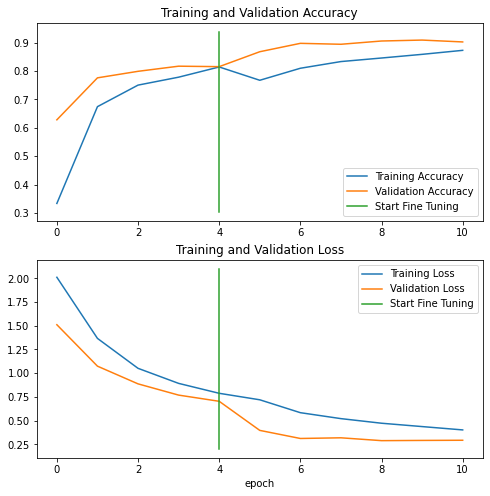

In [62]:
compare_historys(history_2,history_4_fine_tune,initial_epochs = 5)

## Viewing our experiment data on TensorBoard

Right now our experimental results are scattered all throughout our notebook. If we want to share them with someone, they'd be getting a bunch of different graphs and metrics... not a fun time.

But guess what?

Thanks to the TensorBoard callback we made with our helper function `create_tensorflow_callback()`, we've been tracking our modelling experiments the whole time.

How about we upload them to TensorBoard.dev and check them out?

We can do with the `tensorboard dev upload` command and passing it the directory where our experiments have been logged.

> 🔑 **Note:** Remember, whatever you upload to TensorBoard.dev becomes public. If there are training logs you don't want to share, don't upload them.

In [ ]:
# View tensorboard logs of transfer learning modelling experiments (should be 4 models)
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./transfer_learning \
  --name "Transfer learning experiments" \
  --description "A series of different transfer learning experiments with varying amounts of data and fine-tuning" \
  --one_shot # exits the uploader when upload has finished

In [64]:
# View previous experiments
!tensorboard dev list

2021-09-17 21:11:24.896531: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-17 21:11:24.906618: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-17 21:11:24.907221: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
https://tensorboard.dev/experiment/MegQLPRxS9u2fxjh06BjOg/
	Name                 Transfer learning experiments
	Description          A series of different transfer learning experiments with varying amounts of data and fine-tuning
	Id                   MegQLPRxS9u2fxjh06BjOg
	Created              2021-09-17 21:09:23 (2 minutes ago)
	Update

In [65]:
# Remove previous experiments
# !tensorboard dev delete --experiment_id OUbW0O3pRqqQgAphVBxi8Q